In [1]:
# This file makes ET averages for the time intervals. 
# Note that randomness would need to be inserted before this step in order to bootstrap. 

# Anna Boser November 5, 2021

from pyprojroot import here
import rasterio
from rasterio.plot import show
import datetime
import numpy as np
import pandas as pd
import csv
# from os import listdir

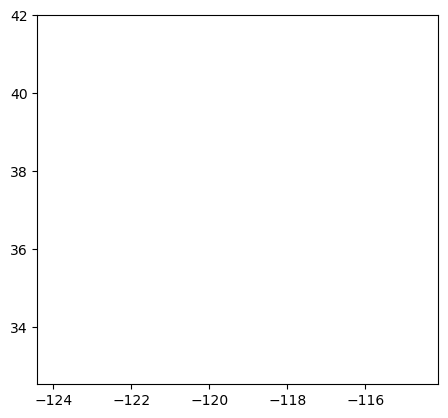

<AxesSubplot:>

In [2]:
# read in raster
img = rasterio.open(here("./data/intermediate/ECOSTRESS/ETinst_OGunits_1.tif"))
show(img)

In [3]:
array = np.array(img.read())
# array = array[0:2,:,:]
# array[array == -3.4e+38] = np.NaN
array.shape #date lon lat

(50, 15017, 16289)

In [12]:
array[array < 0] = np.NaN
array.shape

(2, 15017, 16289)

In [13]:
np.unique(array)

array([0.        , 0.00105274, 0.00112174, ...,        nan,        nan,
              nan], dtype=float32)

In [14]:
# average by time interval

# get dates
dates_list = pd.read_csv(here("./data/intermediate/ECOSTRESS/dates.csv"))['x'].tolist()

# these are the start dates of the wanted time intervals
date_starts = [datetime.date(day = d, month = m, year = y) for y in (2019, 2020) for m in range(1, 13) for d in (1,15)]
del date_starts[5:9]
del date_starts[-3:-1]
del date_starts[-1]

# index of image on or nearest after start date
start_index = [date_list.index(min([i for i in date_list if i >= date_start], key=lambda x:x-date_start)) + 1 for date_start in date_starts] # plus one since bands are 1 indexed

# index of image on or nearest previous to start date + 61 days (this is for a non-inclusive index range so this date will be the first one not to be included in a subset)
end_index = [date_list.index(min([i for i in date_list if i <= date_start + datetime.timedelta(days=61)], key=lambda x:date_start+datetime.timedelta(days=61)-x)) + 1 for date_start in date_starts] # plus one since bands are 1 indexed

#average by time interval
newarray = np.stack([array[start_index[i]:end_index[i]].mean(axis = 0) for i in range(0,len(start_index))], axis=0)
newarray.shape

['2019-01-27',
 '2019-01-28',
 '2019-01-28',
 '2019-01-29',
 '2019-01-29',
 '2019-01-29',
 '2019-02-01',
 '2019-02-02',
 '2019-05-30',
 '2019-05-31']

In [ ]:
# save 

# get metadata
metadata = img.profile
metadata['count'] = 41 # 41 different time intervals

# write your new raster
with rasterio.open(here("./data/intermediate/ECOSTRESS/ETinst_rolling_average.tif"), 'w', **metadata) as dst:
    dst.write(newarray)